In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
from shapely.geometry import LineString
import pandas as pd
from matplotlib.ticker import FormatStrFormatter
import scipy.constants

plt.style.use('../main/multi_py/Bergemann2020.mplstyle')

ModuleNotFoundError: No module named 'shapely'

In [ ]:
with open('../mdata/sol_int_renorm', "rb") as f:
    sol_int_renorm = pickle.load(f)
with open('../mdata/sol_lam_range_list', "rb") as f:
    sol_lam_range_list = pickle.load(f)
with open('../mdata/normalised_intensities/1DLTE', "rb") as f:
    sim_int_1d_norm_ar = pickle.load(f)
with open('../mdata/normalised_intensities/1DNLTE', "rb") as f:
    sim_int_1dnlte_norm_ar = pickle.load(f)
with open('../mdata/normalised_intensities/3DLTE', "rb") as f:
    sim_int_3dlte_norm_ar = pickle.load(f)
with open('../mdata/normalised_intensities/3DNLTE', "rb") as f:
    sim_int_3d_norm_ar = pickle.load(f)
with open('../mdata/normalised_intensities/3DNLTE', "rb") as f:
    sim_int_3d_norm_ar = pickle.load(f)
with open('../mdata/line_lams', "rb") as f:
    line_lams = pickle.load(f)
with open('../mdata/sol_mus', "rb") as f:
    sol_mus = pickle.load(f)
m3d_centre_wavelengths = [5645.613, 5684.484, 5701.104, 5772.146, 7034.901]
remaining_centre_wavelengths = [5645.613, 5772.146, 7034.901]

In [ ]:
def get_bisector_nofit(lambdas, intensities, kr, mu, sim=True):

    this_intensity=intensities[kr][mu]
    if sim==False:
        this_lams=lambdas[kr][mu]
        ind = [i for i, x in enumerate(this_lams) if x > (m3d_centre_wavelengths[kr]-0.3) and x < (m3d_centre_wavelengths[kr]+0.3)]
    else:
        this_lams=lambdas[kr]
        ind = [i for i, x in enumerate(this_lams) if x > (m3d_centre_wavelengths[kr]-0.3) and x < (m3d_centre_wavelengths[kr]+0.3)]


    # ind = [i for i, x in enumerate(lambdas[kr]) if x > (m3d_centre_wavelengths[kr]-0.3) and x < (m3d_centre_wavelengths[kr]+0.3)]

    filtered_int = this_intensity[ind]
    filtered_lams = this_lams[ind] - m3d_centre_wavelengths[kr]
    
    # xx = np.linspace(-0.3, 0.3, 100)
    y = filtered_int
    
    # make range of line y to sample
    ys = np.linspace(np.min(filtered_int)+0.005, 0.87, 20)

    def get_midpoint(y, x):
        f = np.ones(len(x))*y
        g = filtered_int

        first_line = LineString(np.column_stack((x, f)))
        second_line = LineString(np.column_stack((x, g)))
        intersection = first_line.intersection(second_line)

        x_intercecpt,_ = LineString(intersection).xy
        midpoint = np.sum(x_intercecpt)/2
        # if intersection.geom_type == 'MultiPoint':
        #     plt.plot(*LineString(intersection).xy, 'o')
        # elif intersection.geom_type == 'Point':
        #     plt.plot(*intersection.xy, 'o')

        return midpoint
    midpoints = []
    for y in ys:
        midpoints.append([get_midpoint(y,filtered_lams)])

    d = {'midpoints':midpoints, 'intensities':ys}
    return pd.DataFrame(data=d)


In [ ]:
# bisector dictionaries are indexed as (krindex,muindex) and consist of a dataframe with wavelength, intensity columns

NLTE3D_bisectors = {}
LTE3D_bisectors = {}
NLTE1D_bisectors = {}
LTE1D_bisectors = {}
IAG_bisectors = {}
for i, line in enumerate([0,3,4]):
    for j, thismu in enumerate(sol_mus):
        NLTE3D_bisectors[(i,j)] = get_bisector_nofit(line_lams, sim_int_3d_norm_ar, i,j)
        LTE3D_bisectors[(i,j)] = get_bisector_nofit(line_lams, sim_int_3dlte_norm_ar, i,j)
        NLTE1D_bisectors[(i,j)] = get_bisector_nofit(line_lams, sim_int_1dnlte_norm_ar, i,j)
        LTE1D_bisectors[(i,j)] = get_bisector_nofit(line_lams, sim_int_1d_norm_ar, i,j)
        IAG_bisectors[(i,j)] = get_bisector_nofit(sol_lam_range_list, sol_int_renorm, i,j, sim=False)

/tmp/ipykernel_94611/1861333653.py:31: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  x_intercecpt,_ = LineString(intersection).xy
/groups/astro/ngray/.local/lib/python3.8/site-packages/shapely/geometry/linestring.py:46: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  ret = geos_linestring_from_py(coordinates)


In [ ]:
def wav2dop_vel(wavlength_shift, rest_wavelength):
    '''Return Doppler shift in km/s'''
    return scipy.constants.c * np.divide(wavlength_shift,rest_wavelength) * 1e-3

Text(0.5, 0, '$\\Delta \\lambda$ Å')

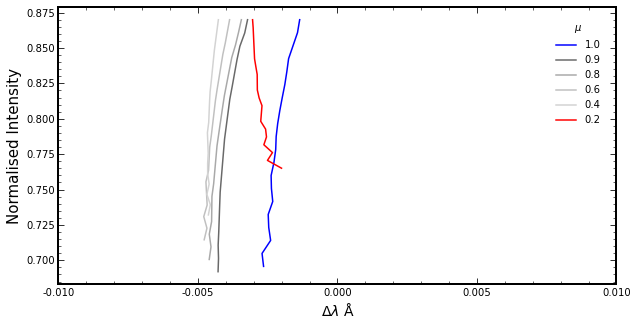

In [ ]:
fig, ax = plt.subplots(1, figsize=(10,5))
# for i, line in enumerate([0,3,4]):
colours = ['b','dimgrey','darkgrey','silver','lightgrey','r']
styles = ['-','-','-','-','-','-']
for i, line in enumerate([0]):
    for j, thismu in enumerate(sol_mus):
        ax.plot(list(NLTE3D_bisectors[(i,j)].midpoints),list(NLTE3D_bisectors[(i,j)].intensities), label=thismu, color=colours[j], linestyle=styles[j])
ax.set_xlim(-0.01,0.01)
ax.legend(title='$\mu$')
ax.set_xticks(ticks=np.linspace(-0.01, 0.01,5) ,labels=np.linspace(-0.01,0.01,5))        
ax.set_ylabel('Normalised Intensity', fontsize=15)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.set_xlabel('$\Delta \lambda$ Å', fontsize=14)
# fig.savefig('../plots/bisect3DNLTE.png')

Text(0.5, 0, '$\\Delta \\lambda$ Å')

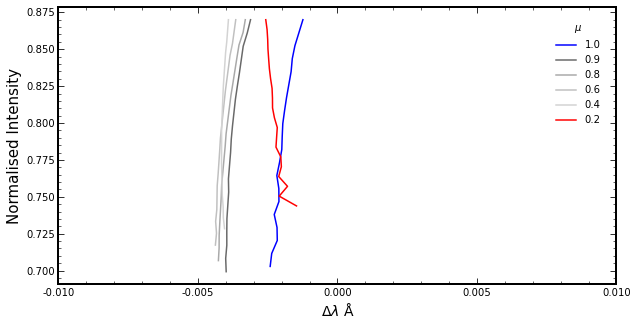

In [ ]:
fig, ax = plt.subplots(1, figsize=(10,5))
# for i, line in enumerate([0,3,4]):
colours = ['b','dimgrey','darkgrey','silver','lightgrey','r']
styles = ['-','-','-','-','-','-',]
for i, line in enumerate([0]):
    for j, thismu in enumerate(sol_mus):
        ax.plot(list(LTE3D_bisectors[(i,j)].midpoints),list(LTE3D_bisectors[(i,j)].intensities), label=thismu, color=colours[j], linestyle=styles[j])
ax.set_xlim(-0.01,0.01)
ax.legend(title='$\mu$')
ax.set_xticks(ticks=np.linspace(-0.01, 0.01,5) ,labels=np.linspace(-0.01,0.01,5))        
ax.set_ylabel('Normalised Intensity', fontsize=15)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.set_xlabel('$\Delta \lambda$ Å', fontsize=14)
# fig.savefig('../plots/bisect3DLTE.png')

Text(0.5, 0, '$\\Delta \\lambda$ Å')

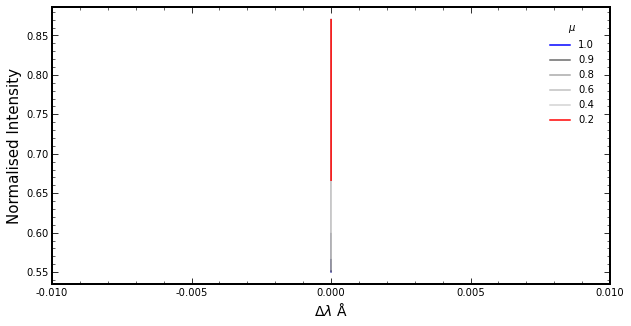

In [ ]:
fig, ax = plt.subplots(1, figsize=(10,5))
# for i, line in enumerate([0,3,4]):
colours = ['b','dimgrey','darkgrey','silver','lightgrey','r']
styles = ['-','-','-','-','-','-',]
for i, line in enumerate([0]):
    for j, thismu in enumerate(sol_mus):
        ax.plot(list(LTE1D_bisectors[(i,j)].midpoints),list(LTE1D_bisectors[(i,j)].intensities), label=thismu, color=colours[j], linestyle=styles[j])

ax.set_xlim(-0.01,0.01)
ax.legend(title='$\mu$')
ax.set_xticks(ticks=np.linspace(-0.01, 0.01,5) ,labels=np.linspace(-0.01,0.01,5))        
ax.set_ylabel('Normalised Intensity', fontsize=15)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.set_xlabel('$\Delta \lambda$ Å', fontsize=14)
# fig.savefig('../plots/bisect1DLTE.png')

Text(0.5, 0, '$\\Delta \\lambda$ Å')

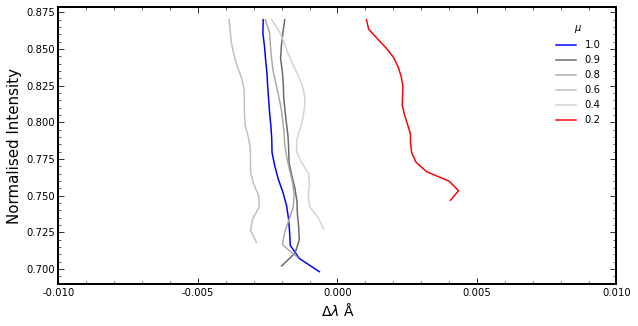

In [ ]:
fig, ax = plt.subplots(1, figsize=(10,5))
# for i, line in enumerate([0,3,4]):
colours = ['b','dimgrey','darkgrey','silver','lightgrey','r']
styles = ['-','-','-','-','-','-',]
for i, line in enumerate([0]):
    for j, thismu in enumerate(sol_mus):
        ax.plot(list(IAG_bisectors[(i,j)].midpoints),list(IAG_bisectors[(i,j)].intensities), label=thismu, color=colours[j], linestyle=styles[j])

ax.set_xlim(-0.01,0.01)
ax.legend(title='$\mu$')
ax.set_xticks(ticks=np.linspace(-0.01, 0.01,5) ,labels=np.linspace(-0.01,0.01,5))
ax.set_ylabel('Normalised Intensity', fontsize=15)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.set_xlabel('$\Delta \lambda$ Å', fontsize=14)

# ax.plot(sol_lam_range_list[0,0]-m3d_centre_wavelengths[0] ,sol_int_renorm[0,0])
# fig.savefig('../plots/bisectIAG.png')

## Replot on same figure

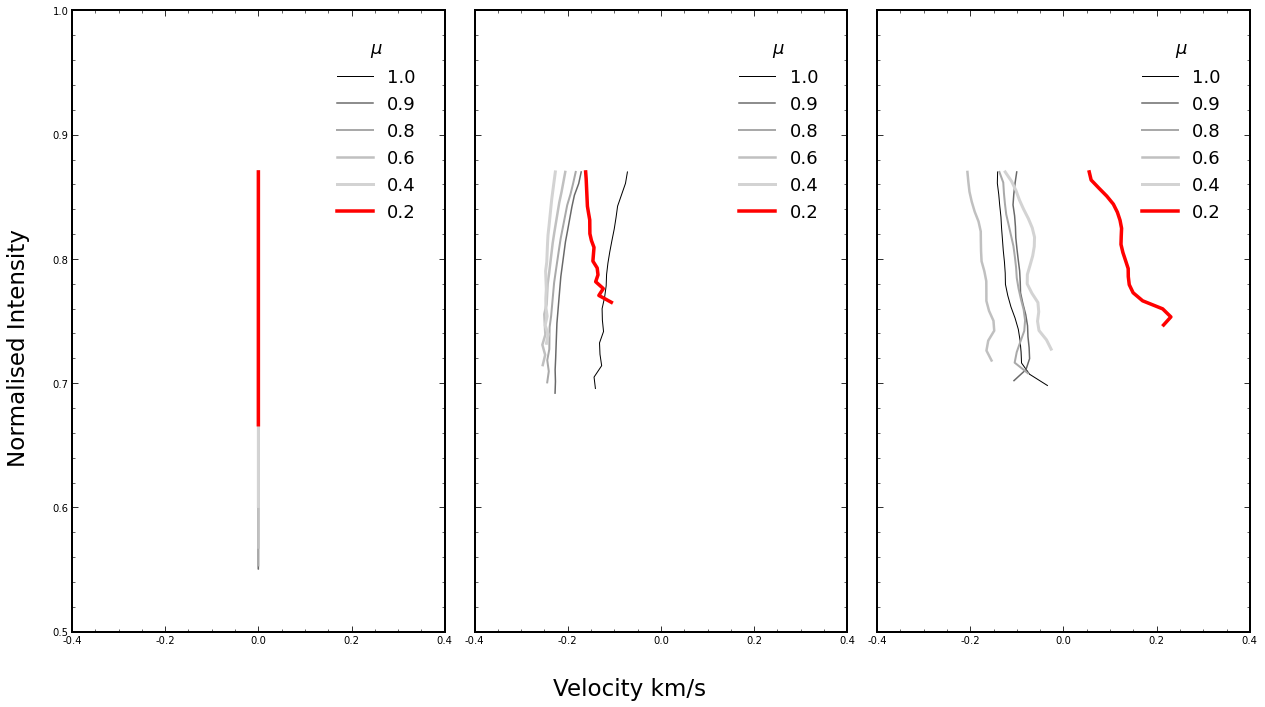

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(18,10), sharey=True)
plt.rcParams.update({'font.size': 18})
# plt.rcParams.update({'axes.labelsize': 2})



colours = ['k','dimgrey','darkgrey','silver','lightgrey','r']
widths = np.arange(1,4,0.5)
kr=0
for i_, i in enumerate([kr]):
    for j, thismu in enumerate(sol_mus):
        for s, sim in enumerate([LTE1D_bisectors, NLTE3D_bisectors, IAG_bisectors]):
            midpoint_velocities = wav2dop_vel( list(sim[(i,j)].midpoints), remaining_centre_wavelengths[i] )
            ax[s].plot(midpoint_velocities, list(sim[(i,j)].intensities), label=thismu, color=colours[j], linewidth=widths[j])
            # ax[s].plot(list(NLTE3D_bisectors[(i,j)].midpoints),list(NLTE3D_bisectors[(i,j)].intensities), label=thismu, color=colours[j], linestyle=styles[j])
            # ax[s].plot(list(IAG_bisectors[(i,j)].midpoints),list(IAG_bisectors[(i,j)].intensities), label=thismu, color=colours[j], linestyle=styles[j])


for ix in [0,1,2]:

    ax[ix].set_xlim(-0.4,0.4)
    ax[ix].set_ylim(0.5,1)

    ax[ix].legend(title='$\mu$', frameon=False)
    ax[ix].set_xticks(ticks=np.linspace(-0.4,0.4,5) ,labels=np.linspace(-0.4,0.4,5))        
    ax[ix].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
fig.supxlabel('Velocity km/s', fontsize=23)
fig.supylabel('Normalised Intensity', fontsize=23)
plt.tight_layout()
plt.subplots_adjust(left=0.07, bottom=None, right=None, top=None, wspace=0.08, hspace=None)
# fig.savefig('../plots/bisectors_threepanels.png')


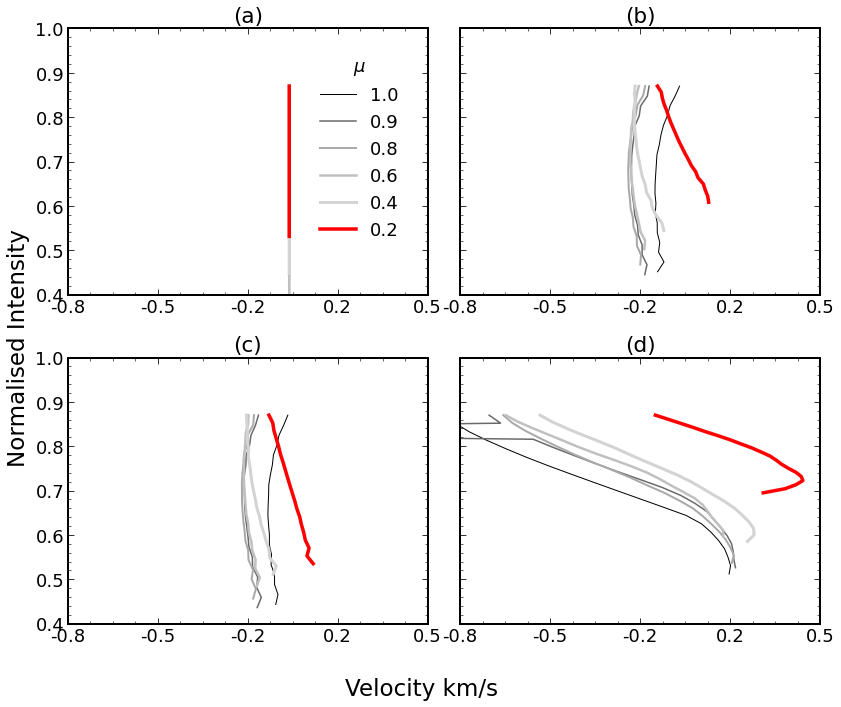

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(12,10), sharey=True)
plt.rcParams.update({'font.size': 18})
# plt.rcParams.update({'axes.labelsize': 2})



colours = ['k','dimgrey','darkgrey','silver','lightgrey','r']
widths = np.arange(1,4,0.5)
coords = [(0,0),(0,1),(1,0),(1,1)]
titles = ['(a)', '(b)','(c)', '(d)']
kr=1

for i_, i in enumerate([kr]):
    for j, thismu in enumerate(sol_mus):
        for s, sim in enumerate([LTE1D_bisectors, NLTE3D_bisectors, LTE3D_bisectors, IAG_bisectors]):
            ix= coords[s]
            midpoint_velocities = wav2dop_vel( list(sim[(i,j)].midpoints), remaining_centre_wavelengths[i] )
            ax[ix].plot(midpoint_velocities, list(sim[(i,j)].intensities), label=thismu, color=colours[j], linewidth=widths[j])
            # ax[s].plot(list(NLTE3D_bisectors[(i,j)].midpoints),list(NLTE3D_bisectors[(i,j)].intensities), label=thismu, color=colours[j], linestyle=styles[j])
            # ax[s].plot(list(IAG_bisectors[(i,j)].midpoints),list(IAG_bisectors[(i,j)].intensities), label=thismu, color=colours[j], linestyle=styles[j])

            ax[ix].set_xlim(-0.8,0.5)
            ax[ix].set_ylim(0.4,1)
            ax[ix].set_title(titles[s])

            if ix==(0,0):
                ax[ix].legend(title='$\mu$', frameon=False)
            ax[ix].set_xticks(ticks=np.linspace(-0.8,0.5,5) ,labels=np.linspace(-0.8,0.5,5))        
            ax[ix].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))



    
fig.supxlabel('Velocity km/s', fontsize=23)
fig.supylabel('Normalised Intensity', fontsize=23)
plt.tight_layout()
plt.subplots_adjust(left=0.09, bottom=None, right=None, top=None, wspace=0.09, hspace=None)
# fig.savefig('../plots/bisectors_fourpanels_5772.png')


In [ ]:
plt.rcParams.keys() 

KeysView(RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.formatter.useoffset': True,
          'axes.grid': False,
          'axes.grid.axis': 'both',
          'axes.gri